<a href="https://colab.research.google.com/github/candrea/AnalisisPZI/blob/main/PruebaTecnica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sqlalchemy import create_engine
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker
from google.colab import drive
#drive.mount('/content/drive')
#engine = create_engine('sqlite:////content/drive/MyDrive/Colab Notebooks/newspaper.db')
engine = create_engine('sqlite:///:memory:')

Session = sessionmaker(bind=engine)

Base = declarative_base()

In [2]:
from sqlalchemy import Column, String, Integer
#import Base
class Article(Base):
    __tablename__ = 'PIB'

    DIVIPOLA = Column(Integer, primary_key=True)
    DEPARTAMENTO = Column(String)
    _2020 = Column(Integer)
   

    def __init__(self,
                 DIVIPOLA,
                 DEPARTAMENTO,
                 _2020):
        self.id = DIVIPOLA
        self.DIVIPOLA= DIVIPOLA
        self.DEPARTAMENTO = DEPARTAMENTO
        self._2020= _2020

class Institucion(Base):
    __tablename__ = 'Instituciones'
    codigo_institucion = Column(Integer, primary_key=True)
    divipola= Column(String)
    departamento = Column(Integer)
    certificado_calidad = Column(String)
    anno_corte = Column(Integer)
   

    def __init__(self,
                 codigo_institucion,
                 cod_dpto,
                 departamento,
                 certificado_calidad,
                 año_corte):
        self.id = codigo_institucion
        self.divipola= cod_dpto
        self.departamento = departamento
        self.certificado_calidad = certificado_calidad
        self.anno_corte= año_corte
       


In [3]:
import argparse
import logging
logging.basicConfig(level=logging.INFO)
import pandas as pd
import requests
import io
parser = argparse.ArgumentParser()
logger = logging.getLogger(__name__)
Base.metadata.create_all(engine)


session = Session()

url ="https://raw.githubusercontent.com/candrea/AnalisisPZI/main/PIB_DEPARTAMENTOS.csv" #"https://github.com/candrea/AnalisisPZI/blob/main/PIB_departamento.csv"
url2 = "https://raw.githubusercontent.com/candrea/AnalisisPZI/main/INSTITUCIONES_TRABAJO.csv"
#s = requests.get(url).content
#c = pd.read_csv(s)
s = requests.get(url, verify=False).content
s2 = requests.get(url2, verify=False).content
#articles = pd.read_csv(io.StringIO(s.decode('utf-8')))
articles = pd.read_csv(url, sep = ';', on_bad_lines='skip')
instituciones = pd.read_csv(url2, sep = ';', on_bad_lines='skip')
#articles
#articles = pd.read_csv(s)
for index, row in articles.iterrows():
  
  logger.info('Loading DIVIPOLA {} into DB'.format(row['DIVIPOLA']))
  article = Article(row['DIVIPOLA'],
                    row['DEPARTAMENTO'],
                    row['_2020'])

  
  session.add(article)
for index, row in instituciones.iterrows():
  
  #logger.info('Loading institucion {} into DB'.format(row['codigo_institucion']))
  institucion = Institucion(row['codigo_institucion'],
                            row['cod_dpto'],
                            row['departamento'],
                            row['certificado_calidad'],
                            row['año_corte'])

  session.add(institucion)


session.commit()

session.close()




INFO:numexpr.utils:NumExpr defaulting to 2 threads.
/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
INFO:__main__:Loading DIVIPOLA 91 into DB
INFO:__main__:Loading DIVIPOLA 5 into DB
INFO:__main__:Loading DIVIPOLA 81 into DB
INFO:__main__:Loading DIVIPOLA 8 into DB
INFO:__main__:Loading DIVIPOLA 11 into DB
INFO:__main__:Loading DIVIPOLA 13 into DB
INFO:__main__:Loading DIVIPOLA 15 into DB
INFO:__main__:Loading DIVIPOLA 17 into DB
INFO:__main__:Loading DIVIPOLA

In [4]:
from sqlalchemy.sql import text
conn = engine.connect()
conn
session = Session()
s = text(
"SELECT divipola, departamento, SUM(CASE WHEN certificado_calidad='SI' THEN 1 ELSE 0 END)  as certificadas,"
"SUM(CASE WHEN certificado_calidad='NO' THEN 1 ELSE 0 END)   AS no_certificadas,"
"COUNT(1) as total "
"FROM instituciones  GROUP BY 1")
t = text(
"SELECT DIVIPOLA, DEPARTAMENTO, SUM(_2020) AS PIB FROM PIB GROUP BY 1,2"
)
tt= text (
"select p.divipola,p.departamento,SUM(CASE WHEN certificado_calidad='SI' THEN 1 ELSE 0 END)  as certificadas,"
"SUM(CASE WHEN certificado_calidad='NO' THEN 1 ELSE 0 END)   AS no_certificadas,"
"COUNT(distinct codigo_institucion) as total, round(avg(_2020),2) as PIB "
"from PIB p left join instituciones i on p.divipola=i.divipola group by 1,2"
    
)
conn.execute(tt).fetchall()

[(5, 'Antioquia', 90, 394, 484, 148387.0),
 (8, 'Atlántico', 26, 123, 149, 44588.0),
 (11, 'Bogotá D.C.', 76, 370, 446, 260207.0),
 (13, 'Bolívar', 10, 131, 141, 34634.0),
 (15, 'Boyacá', 5, 107, 112, 26484.0),
 (17, 'Caldas', 8, 78, 86, 16860.0),
 (18, 'Caquetá', 1, 26, 27, 4160.0),
 (19, 'Cauca', 3, 126, 129, 18192.0),
 (20, 'Cesar', 5, 76, 81, 17555.0),
 (23, 'Córdoba', 8, 168, 176, 17922.0),
 (25, 'Cundinamarca', 21, 233, 254, 61266.0),
 (27, 'Chocó', 0, 32, 32, 4425.0),
 (41, 'Huila', 2, 88, 90, 16620.0),
 (44, 'La Guajira', 2, 50, 52, 8435.0),
 (47, 'Magdalena', 6, 93, 99, 13604.0),
 (50, 'Meta', 11, 148, 159, 31442.0),
 (52, 'Nariño', 18, 209, 227, 15652.0),
 (54, 'Norte de Santander', 15, 112, 127, 15740.0),
 (63, 'Quindío', 5, 43, 48, 8245.0),
 (66, 'Risaralda', 11, 108, 119, 16501.0),
 (68, 'Santander', 30, 153, 183, 61971.0),
 (70, 'Sucre', 7, 47, 54, 8372.0),
 (73, 'Tolima', 10, 114, 124, 21522.0),
 (76, 'Valle del Cauca', 45, 402, 447, 99700.0),
 (81, 'Arauca', 1, 27, 28, 

In [5]:
df_instituciones = pd.read_sql(s,conn)
df_PIB = pd.read_sql(t,conn)
df_data = pd.read_sql(tt,conn)
df_data


,DIVIPOLA,DEPARTAMENTO,certificadas,no_certificadas,total,PIB
0,5,Antioquia,90,394,484,148387.0
1,8,Atlántico,26,123,149,44588.0
2,11,Bogotá D.C.,76,370,446,260207.0
3,13,Bolívar,10,131,141,34634.0
4,15,Boyacá,5,107,112,26484.0
5,17,Caldas,8,78,86,16860.0
6,18,Caquetá,1,26,27,4160.0
7,19,Cauca,3,126,129,18192.0
8,20,Cesar,5,76,81,17555.0
9,23,Córdoba,8,168,176,17922.0


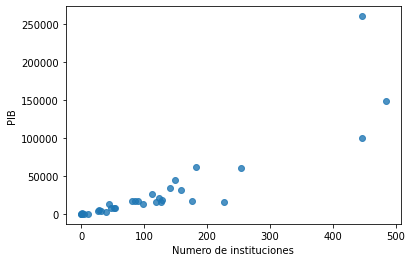

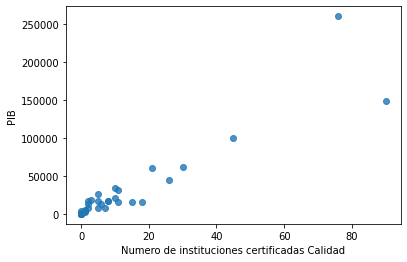

In [6]:
#Graphic analysis
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.scatter(x=df_data.total, y=df_data.PIB, alpha= 0.8)
ax.set_xlabel('Numero de instituciones')
ax.set_ylabel('PIB');
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.scatter(x=df_data.certificadas, y=df_data.PIB, alpha= 0.8)
ax.set_xlabel('Numero de instituciones certificadas Calidad')
ax.set_ylabel('PIB');

In [7]:
import statsmodels.api as sm
!pip install pingouin


In [8]:
import pingouin as pg
from scipy import stats
shapiro_test = stats.shapiro(df_data.total)
print(f"Variable Instituciones: {shapiro_test}")
shapiro_test = stats.shapiro(df_data.PIB)
print(f"Variable PIB: {shapiro_test}")# Normalidad de los residuos D'Agostino's K-squared test
# ==============================================================================
k2, p_value = stats.normaltest(df_data.total)
print(f"Variable Instituciones: Estadítico = {k2}, p-value = {p_value}")
k2, p_value = stats.normaltest(df_data.PIB)
print(f"Variable PIB: Estadítico = {k2}, p-value = {p_value}")

Variable Instituciones: ShapiroResult(statistic=0.7957093715667725, pvalue=2.676149051694665e-05)
Variable PIB: ShapiroResult(statistic=0.5647419691085815, pvalue=9.946437451446855e-09)
Variable Instituciones: Estadítico = 17.749481462175076, p-value = 0.0001398778898815727
Variable PIB: Estadítico = 47.98754054309738, p-value = 3.798726015288439e-11


In [12]:
# Cálculo de correlación, significancia e intervalos con pingouin
# ==============================================================================

display(pg.corr(df_data['total'], df_data['PIB'], method='skipped'))
display(pg.corr(df_data['total'], df_data['PIB'], method='shepherd'))
display(pg.corr(df_data['total'], df_data['PIB'], method='kendall'))
display(pg.corr(df_data['total'], df_data['PIB'], method='spearman'))

/usr/local/lib/python3.7/dist-packages/pingouin/correlation.py:128: UserWarning: The skipped correlation relies on the Minimum Covariance Determinant algorithm, which gives slightly different results in Python (scikit-learn) than in the original Matlab library (LIBRA). As such, the skipped correlation may be different from the Matlab robust correlation toolbox (see issue 164 on Pingouin's GitHub). Make sure to double check your results or use another robust correlation method.
  "The skipped correlation relies on the Minimum Covariance Determinant "


,n,outliers,r,CI95%,p-val,power
skipped,33,5,0.900082,"[0.79, 0.95]",7.109347e-11,1.0


,n,outliers,r,CI95%,p-val,power
shepherd,33,4,0.949495,"[0.89, 0.98]",4.093444e-15,1.0


,n,r,CI95%,p-val,power
kendall,33,0.79317,"[0.62, 0.89]",9.281099e-11,0.999971


,n,r,CI95%,p-val,power
spearman,33,0.932977,"[0.87, 0.97]",2.654317e-15,1.0
